In [1]:
#imports
import numpy as np
import pandas as pd
from HydroModelv2 import hydroPowerList
from MinSpillAdjuster import SpillAdjuster
from HydroFlowAdjustment import flowAdjustment
from WTT import WTT
from SARmodelv3 import SAR_model
from economicsModelv1 import cost
import copy

C:\Users\aidan\AppData\Local\Temp\ipykernel_7512\606863377.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    SAR   No. Observations:                 1004
Model:                            GLM   Df Residuals:                      998
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -78.983
Date:                Sun, 01 Dec 2024   Deviance:                       12.461
Time:                        23:47:21   Pearson chi2:                     13.1
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003649
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.52

In [2]:
#SETUP FOR EA
#set up testing data
graniteUpTraining = pd.read_csv(r'Data\TrainingData\GraniteUpTraining.csv', delimiter=',')
graniteDownTraining = pd.read_csv(r'Data\TrainingData\GraniteDownTraining.csv', delimiter=',')
gooseUpTraining = pd.read_csv(r'Data\TrainingData\GraniteUpTraining.csv', delimiter=',')
gooseDownTraining = pd.read_csv(r'Data\TrainingData\GooseDownTraining.csv', delimiter=',')
monumentalUpTraining = pd.read_csv(r'Data\TrainingData\MonumentalUpTraining.csv', delimiter=',')
monumentalDownTraining = pd.read_csv(r'Data\TrainingData\MonumentalDownTraining.csv', delimiter=',')
iceUpTraining = pd.read_csv(r'Data\TrainingData\IceUpTraining.csv', delimiter=',')
iceDownTraining = pd.read_csv(r'Data\TrainingData\IceDownTraining.csv', delimiter=',')
upTouple = [graniteUpTraining,gooseUpTraining,monumentalUpTraining,iceUpTraining]
downTouple = [graniteDownTraining,gooseDownTraining,monumentalDownTraining,iceDownTraining]

#DAM BREACH STATUS
graniteBreach = False
gooseBreach = False
monumentalBreach = False
iceBreach = False
breachTouple = [graniteBreach,gooseBreach,monumentalBreach,iceBreach] #will change for the 16 scenarios

#dam power capacities
graniteCap = 810
gooseCap = 810
monumentalCap = 810
iceCap = 603
maxPowerTouple = [graniteCap,gooseCap,monumentalCap,iceCap]


Evolutionary algorithm below

In [3]:

#choose data year for evaluation
def dataYear(upTouple,downTouple,year):
    filtered_downTouple = []
    filtered_upTouple = []
    for i in range(4):
        upTouple[i]['Date'] = pd.to_datetime(upTouple[i]['Date'])
        downTouple[i]['Date'] = pd.to_datetime(downTouple[i]['Date'])
        newUp = upTouple[i][upTouple[i]['Date'].dt.year==year]
        newDown = downTouple[i][downTouple[i]['Date'].dt.year==year]
        newUp = newUp.reset_index(drop=True)
        newDown = newDown.reset_index(drop=True)
        filtered_downTouple.append(newDown)
        filtered_upTouple.append(newUp)
    return(filtered_upTouple,filtered_downTouple)

year = 2019 #can change
(upTouple,downTouple) = dataYear(upTouple,downTouple,year)

#find baseline energy production
baselineEnergy = sum(hydroPowerList(upTouple,downTouple,maxPowerTouple)['Total Energy (MWh)'])

In [4]:
#more imports
import itertools
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
from functools import partial

In [5]:
#set up EA

# Define multi-objective fitness
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))  # Minimize both SAR and Economic Impact
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 80)  # Spill range: 0 to 100
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

pd.options.mode.chained_assignment = None  #turn off warnings so I can find errors

# Define dynamic evaluation function
def evaluate(individual, breachTouple, upTouple, downTouple, maxPowerTouple, baselineEnergy, sar_model, econ_model):
    minSpill = individual[0]  # min spill value

    #prevent invalid min spills
    if minSpill > 100:
        # Apply a penalty for invalid values (such as very high fitness or an unreachable solution)
        return (-float('inf'), float('inf'))  # This will result in an invalid individual

    # Adjust touples for spill and breach
    (newUpTouple, newDownTouple) = SpillAdjuster(copy.deepcopy(upTouple), copy.deepcopy(downTouple), minSpill)
    (newUpTouple, newDownTouple) = flowAdjustment(newUpTouple, newDownTouple, breachTouple)

    # Evaluate SAR model
    sar_result = sar_model(newDownTouple, breachTouple)
    # Evaluate economic model
    econ_result = econ_model(newUpTouple, newDownTouple, breachTouple, maxPowerTouple, baselineEnergy)

    fitness = sar_result.item(), econ_result
    if sum(breachTouple)==0:
        print(f"Evaluating Individual {individual} -> Fitness: {fitness}")

    return (fitness)

#copy code for NSGA2 because it can't be imported
def run_nsga2(breachTouple, upTouple, downTouple, maxPowerTouple, baselineEnergy, sar_model, econ_model):
    # Dynamically adapt the evaluation function
    eval_func = partial(
        evaluate,
        breachTouple=breachTouple,
        upTouple=upTouple,
        downTouple=downTouple,
        maxPowerTouple=maxPowerTouple,
        baselineEnergy=baselineEnergy,
        sar_model=sar_model,
        econ_model=econ_model
    )
    toolbox.register("evaluate", eval_func)

    # Create population
    population = toolbox.population(n=5) #change for speed

    # Run NSGA-II
    algorithms.eaMuPlusLambda(
        population=population,
        toolbox=toolbox,
        mu=3, #change for speed
        lambda_=5, #change for speed
        cxpb=0.45,
        mutpb=0.45,
        ngen=2, #change for speed
        stats=None,
        halloffame=None,
        verbose=False,
    )

    # Extract Pareto front
    pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
    return pareto_front

# Dam Breach Scenarios
dams = ["LGR", "LGS", "LMN", "ICE"]
combinations = list(itertools.product([0, 1], repeat=len(dams)))  # All dam breach combinations

In [6]:
pareto_results = []
for scenario in combinations:
    dams_destroyed = [dams[i] for i in range(len(dams)) if scenario[i] == 1]
    pareto_front = run_nsga2(scenario, upTouple, downTouple, maxPowerTouple, baselineEnergy, SAR_model, cost)

    pareto_results.append({
        "scenario": dams_destroyed,
        "pareto_front": [(ind[0], ind.fitness.values) for ind in pareto_front]
    })

Evaluating Individual [8.248910196244514] -> Fitness: (0.021223209042437872, 47790601.546186805)
Evaluating Individual [6.367019123067648] -> Fitness: (0.019368323399110435, 47785201.91304211)
Evaluating Individual [73.20107798848099] -> Fitness: (0.044326970096307074, 48145851.98127398)
Evaluating Individual [24.567293528722498] -> Fitness: (0.031249256782744265, 47838352.22445583)
Evaluating Individual [1.2344880176827289] -> Fitness: (0.013080853286250336, 47770583.95123452)
Evaluating Individual [72.79500216470137] -> Fitness: (0.044256606466131276, 48142064.83803641)
Evaluating Individual [1.2344880176827289] -> Fitness: (0.013080853286250336, 47770583.95123452)
Evaluating Individual [4.31106202472975] -> Fitness: (0.0170806223409163, 47779321.38101662)
Evaluating Individual [23.287520204644782] -> Fitness: (0.0307209287030746, 47834502.561830446)
Evaluating Individual [71.27840004916244] -> Fitness: (0.04398980377038361, 48128024.185108855)
Evaluating Individual [1.23448801768272

In [7]:
print(pareto_results[0]['pareto_front'])

[(73.20107798848099, (0.044326970096307074, 48145851.98127398)), (1.2344880176827289, (0.013080853286250336, 47770583.95123452)), (71.27840004916244, (0.04398980377038361, 48128024.185108855))]


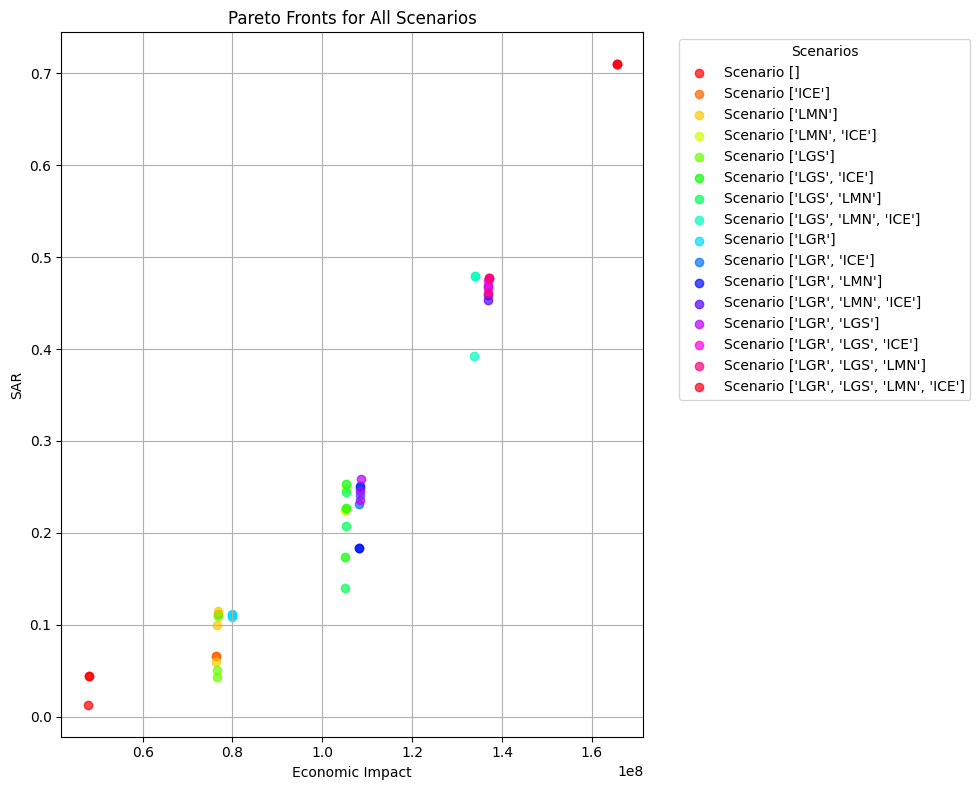

In [11]:
# Define a colormap for different scenarios
colors = plt.cm.hsv(np.linspace(0, 1, len(pareto_results)))  # You can choose any colormap

plt.figure(figsize=(10, 8))

# Loop through all the pareto results and plot on the same graph
for idx, result in enumerate(pareto_results):
    scenario = result["scenario"]
    pareto_front = result["pareto_front"]

    # Extract SAR and economic values for each point in the Pareto front
    sar_values = [fitness[0] for _, fitness in pareto_front]  # SAR values
    econ_values = [fitness[1] for _, fitness in pareto_front]  # Economic values

    # Plot the points for this scenario (all Pareto front points for the scenario)
    plt.scatter(econ_values, sar_values, label=f"Scenario {scenario}", color=colors[idx], alpha=0.7)

# Customize the plot
plt.title("Pareto Fronts for All Scenarios")
plt.xlabel("Economic Impact")
plt.ylabel("SAR")
plt.legend(title="Scenarios", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

    